In [1]:
"""
Pre-processing PlanetScope SuperDove imagery

1. Calculate Spectral Indices:
    a. Normalized Difference Red-edge Index (NDRE)
    b. Visible Green-Based Built-Up Index (VgNIRBI)
    c. Visible Red-Based Built-Up Index (VrNIRBI)
    d. Blue-Green Normalized Built-Up Index (NDBIbg)
    e. Red-Green Normalized Built-up Index (NDBIrg)
    f. Normalized Impervious Surface Index (NISI)

2. Check Band Correlations

3. Minimum Noise Fraction (MNF) Transformation

4. Remove Highly Correlated Bands

5. Texture Calculations

5. Export to GeoTIFF

"""


import os, sys, time
from glob import glob
import rioxarray as rxr
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import earthpy.plot as ep
import rasterio as rio
import pysptools.util as sp_utils
import geopandas as gpd
import warnings
import gc

from rioxarray.merge import merge_arrays
from rasterio.crs import CRS
from sklearn.preprocessing import StandardScaler
from scipy.ndimage import generic_filter

warnings.filterwarnings('ignore')

# Custom functions
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

# Load the environment variables

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-rooftop-mapping'

# Coordinate Ref. System
proj = 32618  # UTM Zone 18N (Washington, D.C.)

print("Ready !")

Ready !


In [2]:
# PSScene list of GeoTIFFs
psscenes = glob(os.path.join(maindir,'data/spatial/raw/dc_data/planet-data/PSScene8Band_23/*_composite.tif'))
# psscenes = glob(os.path.join(maindir,'data/spatial/raw/*/*/*/*_composite.tif'))
print([os.path.basename(f) for f in psscenes])

['2023-06-02_strip_6551610_composite.tif', '2023-06-02_strip_6551575_composite.tif']


In [3]:
# Open the files and store in a list
strips = []
for i in range(len(psscenes)):
    print(os.path.basename(psscenes[i]))
    strip = rxr.open_rasterio(
        psscenes[i],masked=True,cache=False
    ).squeeze().astype(rio.uint16)
    strips.append(strip)  # append to the empty list
    del strip

print(strips[0].rio.crs)
print(strips[0].rio.resolution())
height, width = strips[0].rio.resolution()[0], strips[0].rio.resolution()[1]

2023-06-02_strip_6551610_composite.tif
2023-06-02_strip_6551575_composite.tif
EPSG:32618
(3.0, -3.0)


In [4]:
# Merge the strips
mosaic = merge_arrays(
    dataarrays=strips,
    res=(height, abs(width)),
    crs=CRS.from_epsg(proj),
    nodata=0,
    method='max'
)

# Define the list of long names for each band
long_names = ['coastal_blue', 'blue', 'green_i', 'green', 'yellow', 'red', 'rededge', 'nir']
# Assign long names to each band
mosaic.attrs['long_name'] = tuple(long_names)
# Print raster attributes
shp, gt, wkt, nd = mosaic.shape, mosaic.spatial_ref.GeoTransform, mosaic.rio.crs, mosaic.rio.nodata
print(
    f"Shape: {shp}; \n"
    f"GeoTransform: {gt}; \n"
    f"WKT: {wkt}; \n"
    f"NoData Value: {nd}; \n"
    f"Bands: {mosaic.band}; \n"
    f"Band Names: {mosaic.attrs['long_name']}; \n"
    f"Data Type: {mosaic[0].dtype}")

# Write to disk
out_img = os.path.join(maindir,'data/spatial/mod/dc_data/planet-data/dc_0623_psscene8b.tif')
mosaic.rio.to_raster(
    out_img, compress='zstd', zstd_level=9,
    dtype='uint16', driver='GTiff')
strips = []  # clear the list

print(f"Successfully exported the 8-band composite: {out_img}")

del mosaic, strips, height, width   # clean up
gc.collect()

Shape: (8, 8223, 6714); 
GeoTransform: 315267.0 3.0 0.0 4319298.0 0.0 -3.0; 
WKT: EPSG:32618; 
NoData Value: 0; 
Bands: <xarray.DataArray 'band' (band: 8)> Size: 64B
array([1, 2, 3, 4, 5, 6, 7, 8])
Coordinates:
  * band         (band) int64 64B 1 2 3 4 5 6 7 8
    spatial_ref  int64 8B 0; 
Band Names: ('coastal_blue', 'blue', 'green_i', 'green', 'yellow', 'red', 'rededge', 'nir'); 
Data Type: uint16
Successfully exported the 8-band composite: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-rooftop-mapping/data/spatial/mod/dc_data/planet-data/dc_0623_psscene8b.tif


203

In [5]:
# Reload the mosaic
da = rxr.open_rasterio(out_img, masked=True, cache=False)
print(da)

<xarray.DataArray (band: 8, y: 8223, x: 6714)> Size: 2GB
[441673776 values with dtype=float32]
Coordinates:
  * band         (band) int64 64B 1 2 3 4 5 6 7 8
  * x            (x) float64 54kB 3.153e+05 3.153e+05 ... 3.354e+05 3.354e+05
  * y            (y) float64 66kB 4.319e+06 4.319e+06 ... 4.295e+06 4.295e+06
    spatial_ref  int64 8B 0
Attributes:
    STATISTICS_APPROXIMATE:    YES
    STATISTICS_MAXIMUM:        15296
    STATISTICS_MEAN:           610.98447553229
    STATISTICS_MINIMUM:        16
    STATISTICS_STDDEV:         321.59520811687
    STATISTICS_VALID_PERCENT:  91.15
    AREA_OR_POINT:             Area
    scale_factor:              1.0
    add_offset:                0.0
    long_name:                 ('coastal_blue', 'blue', 'green_i', 'green', '...


In [6]:
# Calculate the spectral indices

# Copy attributes from the Green band (arbitrary, could be any band)
NDRE = da[3].copy(data=(da[7] - da[6]) / (da[7] + da[6])) # red, nir
VgNIRBI = da[3].copy(data=(da[3] - da[7]) / (da[3] + da[7]))  # 'green','nir'
VrNIRBI = da[3].copy(data=(da[5] - da[7]) / (da[5] + da[7]))  # 'red','nir'
NDBIbg = da[3].copy(data=(da[1] - da[3]) / (da[1] + da[3]))  # 'blue','green'
NDBIrg = da[3].copy(data=(da[5] - da[3]) / (da[5] + da[3]))  # 'red','green'
NISI = da[3].copy(data=(((da[1] + da[3] + da[5]) - da[7]) / ((da[1] + da[3] + da[5]) + da[7])))

# Put the indices into a list
si_stack = xr.concat([NDRE, VgNIRBI, VrNIRBI, NDBIbg, NDBIrg, NISI], dim='band')  # create and image stack

# Reorder the band numbers in prep to merge
si_stack = si_stack.assign_coords(band=np.arange(9, 9 + si_stack.shape[0]))

# Define the list of long names for each band
si_long_names = ['NDRE', 'VgNIRBI', 'VrNIRBI', 'NDBIbg', 'NDBIrg', 'NISI']
# Assign long names to each band
si_stack.attrs['long_name'] = tuple(si_long_names)

# Print the attributes
# Print raster attributes
shp, gt, wkt, nd = si_stack.shape, si_stack.spatial_ref.GeoTransform, si_stack.rio.crs, si_stack.rio.nodata
print(
    f"Shape: {shp}; \n"
    f"GeoTransform: {gt}; \n"
    f"WKT: {wkt}; \n"
    f"NoData Value: {nd}; \n"
    f"Bands: {si_stack.band}; \n"
    f"Band Names: {si_stack.attrs['long_name']}; \n"
    f"Data Type: {si_stack[0].dtype}")

del NDRE, VgNIRBI, VrNIRBI, NDBIbg, NDBIrg, NISI
gc.collect()

Shape: (6, 8223, 6714); 
GeoTransform: 315267.0 3.0 0.0 4319298.0 0.0 -3.0; 
WKT: EPSG:32618; 
NoData Value: nan; 
Bands: <xarray.DataArray 'band' (band: 6)> Size: 48B
array([ 9, 10, 11, 12, 13, 14])
Coordinates:
    spatial_ref  int64 8B 0
  * band         (band) int64 48B 9 10 11 12 13 14; 
Band Names: ('NDRE', 'VgNIRBI', 'VrNIRBI', 'NDBIbg', 'NDBIrg', 'NISI'); 
Data Type: float32


0

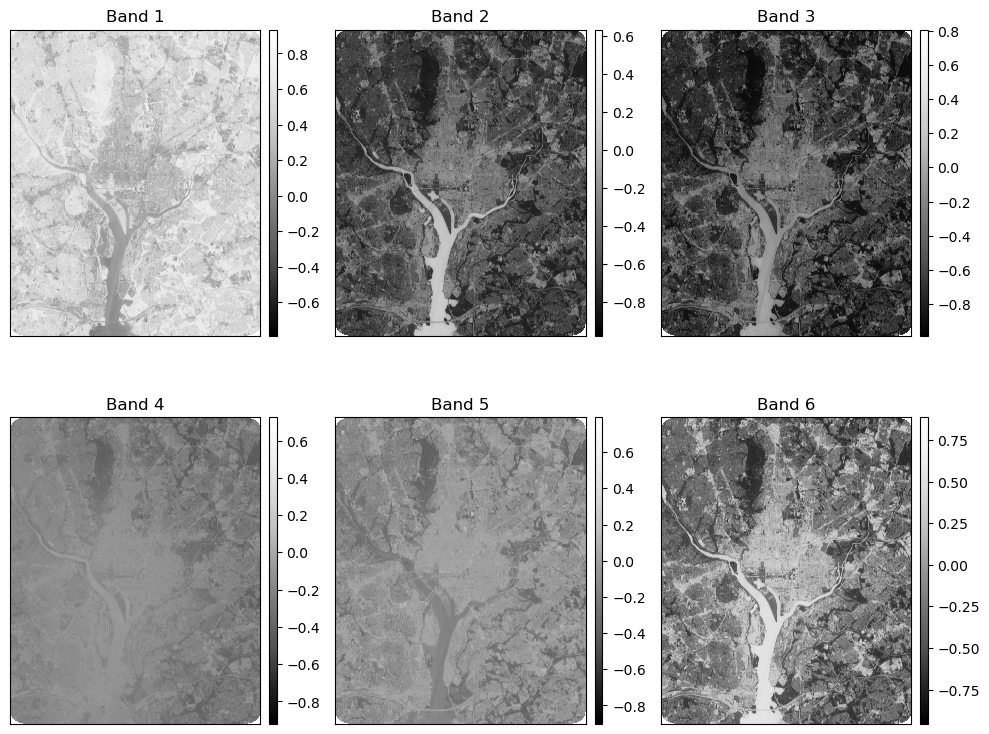

array([[<Axes: title={'center': 'Band 1'}>,
        <Axes: title={'center': 'Band 2'}>,
        <Axes: title={'center': 'Band 3'}>],
       [<Axes: title={'center': 'Band 4'}>,
        <Axes: title={'center': 'Band 5'}>,
        <Axes: title={'center': 'Band 6'}>]], dtype=object)

In [7]:
ep.plot_bands(si_stack, scale=False, figsize=(10,8))

In [8]:
# Stack the original SuperDove bands and the spectral indices

shape: (14, 8223, 6714);
long_name: ('coastal_blue', 'blue', 'green_i', 'green', 'yellow', 'red', 'rededge', 'nir', 'NDRE', 'VgNIRBI', 'VrNIRBI', 'NDBIbg', 'NDBIrg', 'NISI')


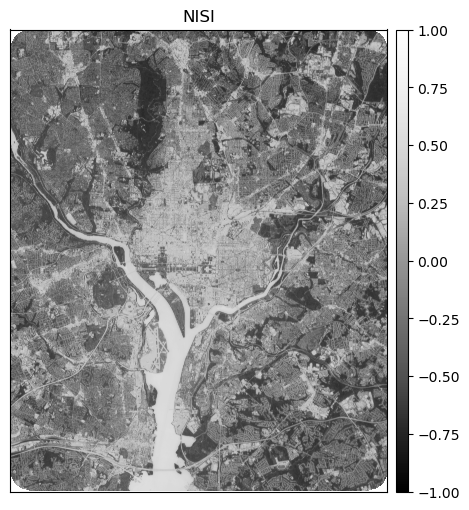

<Axes: title={'center': 'NISI'}>

In [9]:
# Create the final multi-band image stack
da_stack = xr.concat([da, si_stack], dim='band').astype(np.float32)

# Update the long_name attribute to include the other names
long_names = list(da_stack.attrs['long_name']) + si_long_names
da_stack.attrs['long_name'] = tuple(long_names)
print(f"shape: {da_stack.shape};\nlong_name: {da_stack.attrs['long_name']}")

# Test by plotting the 9th band (should be vgnir)
ep.plot_bands(
    da_stack[13].squeeze(),
    scale=False,
    vmin=-1,vmax=1,
    title="NISI",
    figsize=(6,6))

In [10]:
del da, si_stack
gc.collect()

120

### Examine Band Correlations

In [11]:
# Convert to a numpy array and test band correlations
image_np = da_stack.values
# img_data is now a numpy array of shape (bands, height, width)
print(f"Image data shape: {image_np.shape}")
print(f"Data type: {image_np.dtype}")
# Check if the data contains only zeros or NaNs
print(f"Data contains NaNs: {np.isnan(image_np).any()}")
print(f"Data contains only zeros: {np.all(image_np == 0)}")

Image data shape: (14, 8223, 6714)
Data type: float32
Data contains NaNs: True
Data contains only zeros: False


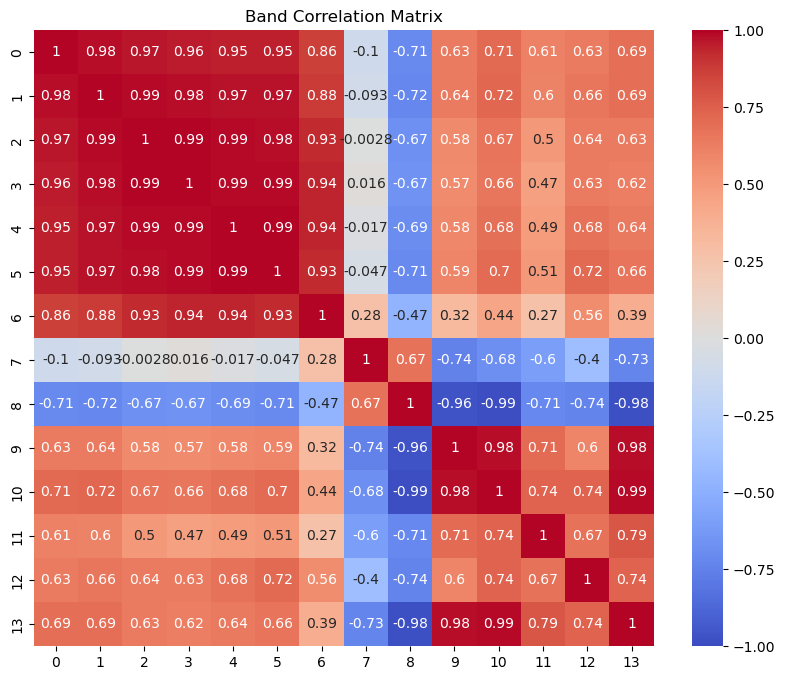

19337

In [12]:
out_png = os.path.join(maindir,'figures/FigX_band_correlations.png')
band_correlations(da_stack, out_png) # see functions.py
gc.collect()

### Calculate Minimum Noise Fraction (MNF) Transform

The Planet SuperDove visible bands (1-7) are highly correlated (all but the NIR). To handle this issue, we can try to distill the information down using a decomposition method. Minimum Noise Fraction minimizes noise in an image, producing sequential images of decreasing quality.

In [13]:
print(f"Image array shape: {image_np.shape}; and type: {type(image_np)}")

Image array shape: (14, 8223, 6714); and type: <class 'numpy.ndarray'>


In [14]:
planet_bands_vis = image_np[:7, ...]
planet_bands_vis = np.nan_to_num(planet_bands_vis, nan=-9999)
print(planet_bands_vis.shape)

(7, 8223, 6714)


In [15]:
# MNF transform implmentation
da_mnf = mnf_transform(planet_bands_vis)  # see functions.py
print(
    f"MNF image shape: {da_mnf.shape}; \n"
    f"transposed shape: {da_mnf.T.shape}; \n"
    f"and type: {type(da_mnf)};")

MNF image shape: (6714, 8223, 7); 
transposed shape: (7, 8223, 6714); 
and type: <class 'numpy.ndarray'>;


In [16]:
# Explore the dimensionality of the data
# Filter out NoData values from the MNF-transformed image
filtered = ravel_and_filter(np.where(planet_bands_vis == -9999, -9999, da_mnf.T))
# Obtain the covariance matrix
cov_m = sp_utils.cov(filtered)
# Compute the eigenvalues, sort them, reverse the sorting
eigenvals = np.sort(np.linalg.eig(cov_m)[0])[::-1]
eigenvals_p = np.power(eigenvals, 2) / sum(np.power(eigenvals, 2))
print(f"Variance explained by MNF rotations: \n {list(map(lambda x: round(x, 3), eigenvals_p.tolist()))}")

Variance explained by MNF rotations: 
 [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [17]:
# retain the first rotation which explains 100% (??) of the variation
da_mnf_ = da_mnf[:,:,:1].T # transpose to match the da stack
print(da_mnf_.shape)

(1, 8223, 6714)


In [18]:
# Export to GeoTIFF
out_path = os.path.join(maindir,'data/spatial/mod/dc_data/planet-data/dc_0623_psscene8b_mnf.tif')
mnf_img = array_to_tif(da_mnf_.T, da_stack, out_path, 'float32', clip=False)  

# Convert to DataArray
mnf_array = xr.DataArray(data=da_mnf_, # transposed mnf array
                         dims=['band','y', 'x'],
                         coords={'y': da_stack.coords['y'], 'x': da_stack.coords['x'], 'band': [15]},
                         attrs=da_stack.attrs)

# Set the long name for the MNF band
mnf_array.attrs['long_name'] = 'mnf1'
mnf_array.rio.write_crs(proj, inplace=True) # write the CRS
print(mnf_array)

(1, 8223, 6714)
Successfully exported array to '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-rooftop-mapping/data/spatial/mod/dc_data/planet-data/dc_0623_psscene8b_mnf.tif'
<xarray.DataArray (band: 1, y: 8223, x: 6714)> Size: 442MB
array([[[-36.79403399, -36.79403403, -36.79403403, ..., -36.79403403,
         -36.79403403, -36.79403403],
        [-36.79403404, -36.79403403, -36.79403403, ..., -36.79403403,
         -36.79403403, -36.79403403],
        [-36.79403402, -36.79403403, -36.79403403, ..., -36.79403403,
         -36.79403403, -36.79403403],
        ...,
        [-36.79403403, -36.79403403, -36.79403403, ..., -36.79403403,
         -36.79403403, -36.79403403],
        [-36.79403403, -36.79403403, -36.79403403, ..., -36.79403403,
         -36.79403403, -36.79403403],
        [-36.79403403, -36.79403403, -36.79403403, ..., -36.79403403,
         -36.79403403, -36.79403403]]])
Coordinates:
  * y            (y) float64 66kB 4.319e+06 4.319e+06 ... 4.295e+06

In [19]:
del da_mnf, da_mnf_, filtered, cov_m, eigenvals, eigenvals_p
gc.collect()

47

In [20]:
# COMBINE THE BANDS IN NEW STACK

In [21]:
# Merge into new data stack with correlated SuperDove bands removed
da_stack_ = da_stack[7:, :, :] # drop the superdove bands
stack_out = xr.concat([da_stack_, mnf_array], dim='band') # Concatenate all bands
print(stack_out.shape)

(8, 8223, 6714)


In [22]:
# Update 'long_name' attribute
new_bands = ['nir', 'NDRE', 'VgNIRBI', 'VrNIRBI', 'NDBIbg', 'NDBIrg', 'NISI', 'MNF1']
stack_out.attrs['long_name'] = new_bands
print(
    f"Shape: {stack_out.shape}; \n"
    f"CRS:  {stack_out.rio.crs}; \n"
    f"NoData Value: {stack_out.rio.nodata}; \n"
    f"Bands: {stack_out.band}; \n"
    f"Band Names: {stack_out.long_name}; \n"
    f"Data Type: {stack_out[0].dtype}")

Shape: (8, 8223, 6714); 
CRS:  EPSG:32618; 
NoData Value: None; 
Bands: <xarray.DataArray 'band' (band: 8)> Size: 64B
array([ 8,  9, 10, 11, 12, 13, 14, 15])
Coordinates:
  * band         (band) int64 64B 8 9 10 11 12 13 14 15
    spatial_ref  int64 8B 0; 
Band Names: ['nir', 'NDRE', 'VgNIRBI', 'VrNIRBI', 'NDBIbg', 'NDBIrg', 'NISI', 'MNF1']; 
Data Type: float64


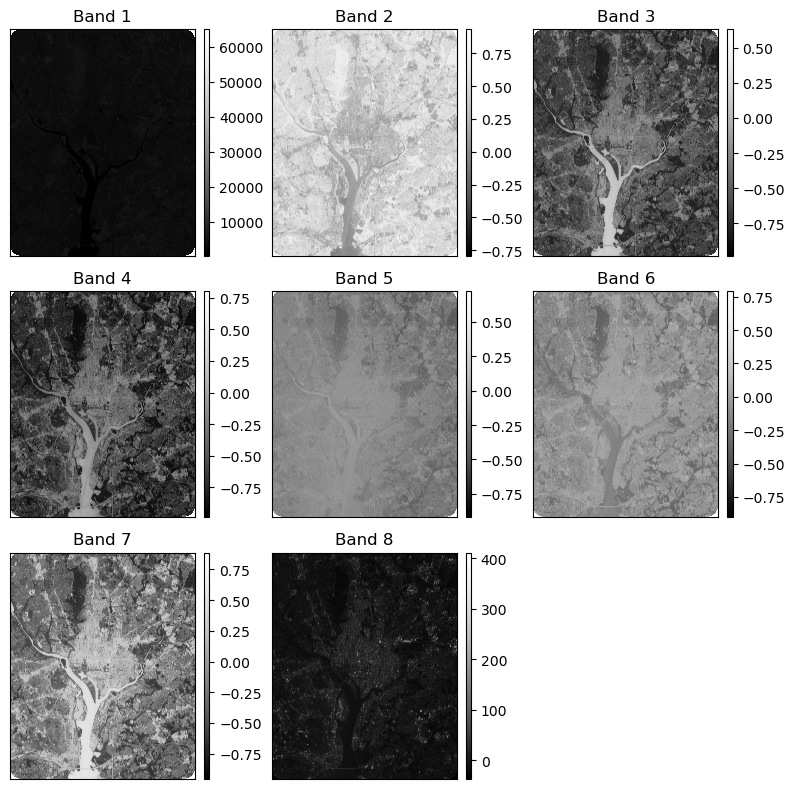

array([[<Axes: title={'center': 'Band 1'}>,
        <Axes: title={'center': 'Band 2'}>,
        <Axes: title={'center': 'Band 3'}>],
       [<Axes: title={'center': 'Band 4'}>,
        <Axes: title={'center': 'Band 5'}>,
        <Axes: title={'center': 'Band 6'}>],
       [<Axes: title={'center': 'Band 7'}>,
        <Axes: title={'center': 'Band 8'}>, <Axes: >]], dtype=object)

In [23]:
# Plot the final bands (MNF + Indices)
ep.plot_bands(stack_out, figsize=(8,8))

In [24]:
del da_stack
gc.collect()

172

In [25]:
# RERUN THE CORRELATION

['nir', 'NDRE', 'VgNIRBI', 'VrNIRBI', 'NDBIbg', 'NDBIrg', 'NISI', 'MNF1']


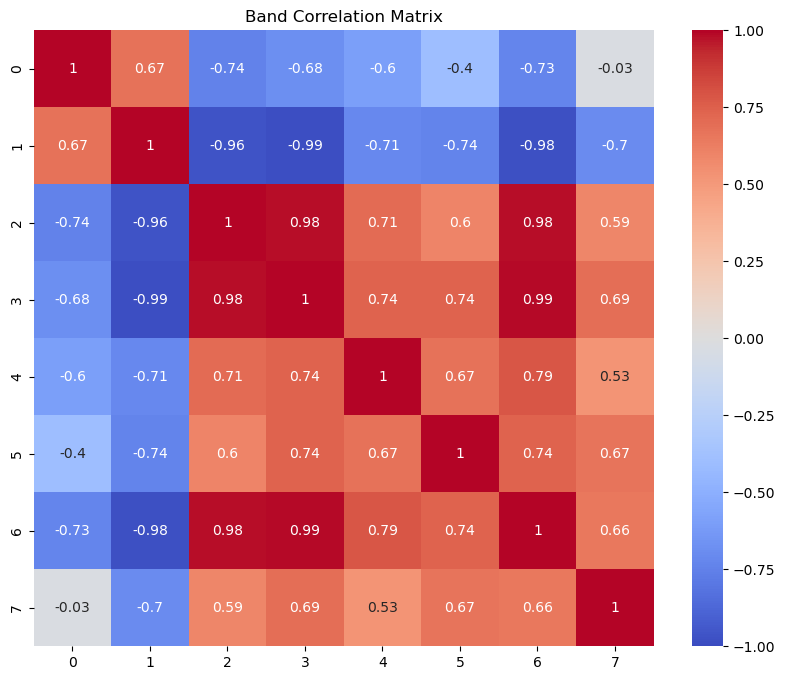

10104

In [26]:
print(new_bands)
# Plot the correlation matrix
out_png = os.path.join(maindir,'figures/FigX_band_correlations_filtered.png')
band_correlations(stack_out, out_png)
gc.collect()

##### It appears that the NDRE, VgNIRBI, and VrNIRBI are all highly correlated. These bands are also highly correlated with the NISI. So, we can remove the three correlated bands and keep NISI ...

In [27]:
# List of long names of the bands to remove
rm_names = ['NDRE', 'VgNIRBI', 'VrNIRBI']
# Get the indices of the bands with matching long names
rm_idx = [i for i, name in enumerate(stack_out.attrs['long_name']) if name in rm_names]
# Remove those bands by index
stack_out_f = stack_out.isel(band=np.delete(np.arange(stack_out.sizes['band']), rm_idx))

# Update the long names
new_names = ['nir', 'NDBIbg', 'NDBIrg', 'NISI', 'MNF1']
stack_out_f.attrs['long_name'] = new_names
print(
    f"Shape: {stack_out_f.shape}; \n"
    f"CRS:  {stack_out_f.rio.crs}; \n"
    f"NoData Value: {stack_out_f.rio.nodata}; \n"
    f"Bands: {stack_out_f.band}; \n"
    f"Band Names: {stack_out_f.long_name}; \n"
    f"Data Type: {stack_out_f[0].dtype}")

Shape: (5, 8223, 6714); 
CRS:  EPSG:32618; 
NoData Value: None; 
Bands: <xarray.DataArray 'band' (band: 5)> Size: 40B
array([ 8, 12, 13, 14, 15])
Coordinates:
  * band         (band) int64 40B 8 12 13 14 15
    spatial_ref  int64 8B 0; 
Band Names: ['nir', 'NDBIbg', 'NDBIrg', 'NISI', 'MNF1']; 
Data Type: float64


In [28]:
del stack_out # free up space
gc.collect()

20

['nir', 'NDBIbg', 'NDBIrg', 'NISI', 'MNF1']


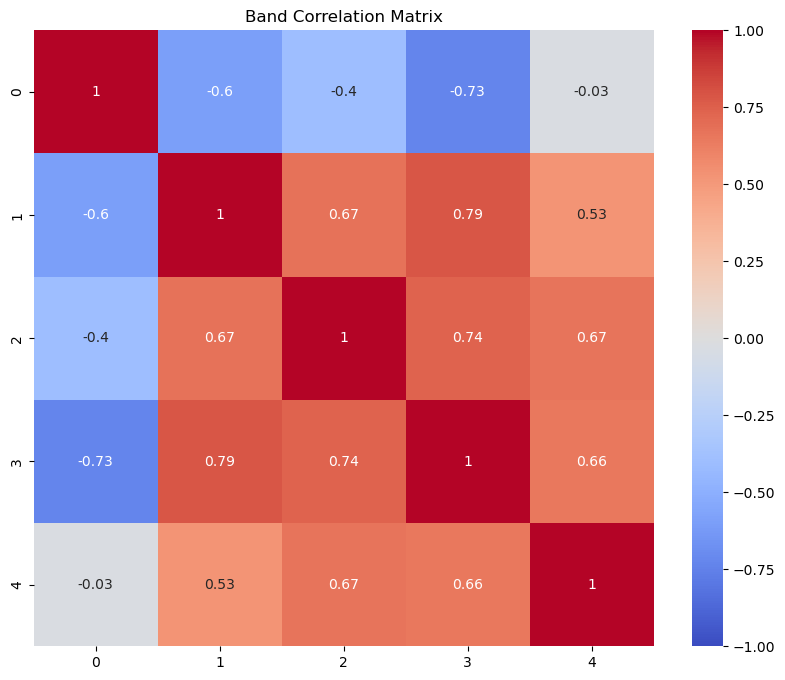

7174

In [29]:
print(new_names)
# Plot the correlation matrix
out_png = os.path.join(maindir,'figures/FigX_band_correlations_filtered_t2.png')
band_correlations(stack_out_f, out_png)
gc.collect()

In [30]:
# TEXTURE ANALYSIS

#### Calculate Simple Texture Features

Now that we have an image stack of uncorrelated bands, we can use some feature extraction to create additional data. In particular, creating textural metrics from the spectral data may improve image classification. In the section below, we calculate image texture using a simple moving window analysis on the Normalised Impervious Surface Index (NISI).

In [32]:
# Select the NISI band for analysis
nisi_band = stack_out_f[3]
print(nisi_band)

<xarray.DataArray (y: 8223, x: 6714)> Size: 442MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    band         int64 8B 14
  * x            (x) float64 54kB 3.153e+05 3.153e+05 ... 3.354e+05 3.354e+05
  * y            (y) float64 66kB 4.319e+06 4.319e+06 ... 4.295e+06 4.295e+06
    spatial_ref  int64 8B 0
Attributes:
    STATISTICS_APPROXIMATE:    YES
    STATISTICS_MAXIMUM:        15296
    STATISTICS_MEAN:           610.98447553229
    STATISTICS_MINIMUM:        16
    STATISTICS_STDDEV:         321.59520811687
    STATISTICS_VALID_PERCENT:  91.15
    AREA_OR_POINT:             Area
    scale_factor:              1.0
    add_offset:                0.0
    long_name:                 ['nir', 'NDBIbg', 'NDBIrg', 'NISI', 'MNF1']


Processing a 9x9 window size ...


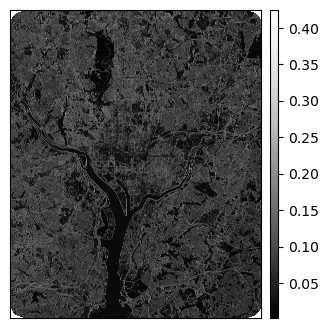

Elapsed time for 9x9: 9.29 minutes.
Processing a 27x27 window size ...


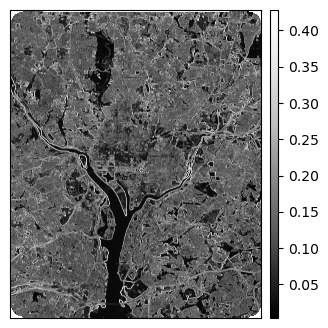

Elapsed time for 27x27: 10.80 minutes.
Total elapsed time: 20.09 minutes.


In [33]:
t0 = time.time()

# Define the window size (N x N)
window_sizes = [9,27]  # 9x9,27x27

da_out = {}

for window_size in window_sizes:
    t00 = time.time()
    name = str(window_size)+'x'+str(window_size)
    print(f"Processing a {name} window size ...")
    
    # Calculate the standard deviation using a moving window
    nisi_std = generic_filter(nisi_band, np.std, size=window_size)
    
    # Convert the result to a DataArray with the same coordinates and dimensions as the original band
    nisi_std_da = xr.DataArray(
        nisi_std,
        dims=nisi_band.dims,
        coords=nisi_band.coords,
        attrs=nisi_band.attrs
    )

    # Prep the array for export as a GeoTIFF
    # Assign the long name attribute
    nisi_std_da.attrs['long_name'] = 'NISI'+str(name)
    nisi_std_da.rio.write_crs(proj, inplace=True) # write the CRS

    # Plot the result to visualize the texture
    ep.plot_bands(nisi_std_da, figsize=(4,4))

    da_out[name] = nisi_std_da

    t1 = (time.time() - t00) / 60
    print(f"Elapsed time for {name}: {t1:.2f} minutes.")

t2 = (time.time() - t0) / 60
print(f"Total elapsed time: {t2:.2f} minutes.")

In [34]:
# Create a multiband image stack from the results
da_texture = xr.concat(list(da_out.values()), dim='band')
# Assign band labels (window sizes) as a coordinate for the 'band' dimension
da_texture = da_texture.assign_coords(band=np.arange(6, 6 + len(da_out)))
# Set the long_name attribute for each band
new_names = ['NISI9x9','NISI27x27']
da_texture.attrs['long_name'] = tuple(new_names)
# View the shape of the multiband texture stack
print(da_texture)

<xarray.DataArray (band: 2, y: 8223, x: 6714)> Size: 883MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * x            (x) float64 54kB 3.153e+05 3.153e+05 ... 3.354e+05 3.354e+05
  * y            (y) float64 66kB 4.319e+06 4.319e+06 ... 4.295e+06 4.295e+06
    spatial_ref  int64 8B 0
  * band         (band) int64 16B 6 7
Attributes:
    STATISTICS_APPROXIMATE:    YES
    STATISTICS_MAXIMUM:        15296
    STATISTICS_MEAN:           610.98447553229
    S

['NISI9x9', 'NISI27x27']


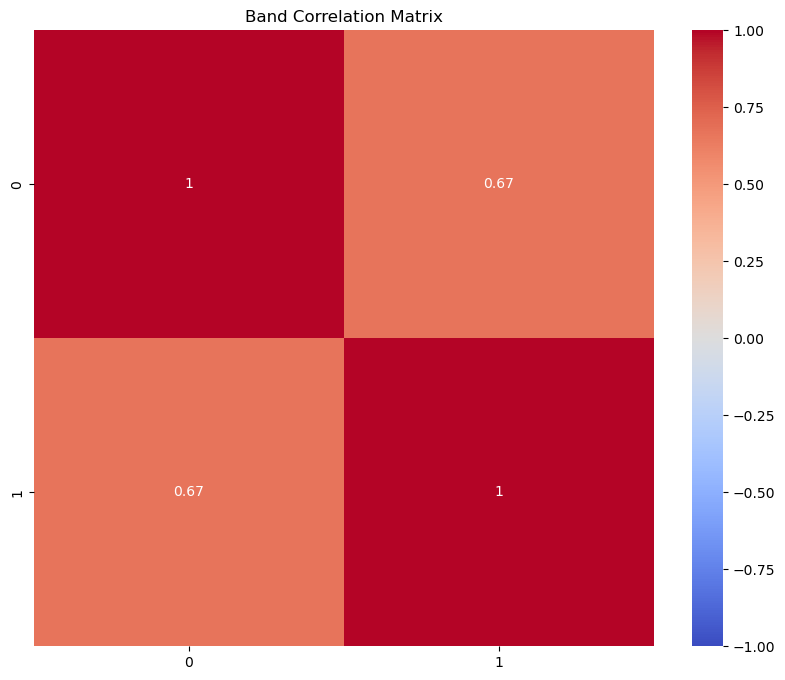

15603

In [35]:
# Test the band correlations to make sure we can keep them all ...
print(new_names)
# Plot the correlation matrix
out_png = os.path.join(maindir,'figures/FigX_band_correlations_texture.png')
band_correlations(da_texture, out_png)
gc.collect()

In [37]:
# Merge with the original data
stack_out_f_t = xr.concat([stack_out_f, da_texture], dim='band') # Concatenate all bands

new_names = ['nir', 'NDBIbg', 'NDBIrg', 'NISI', 'MNF1', 'NISI9x9', 'NISI27x27']
stack_out_f_t.attrs['long_name'] = tuple(new_names)

print(stack_out_f_t.shape)

(7, 8223, 6714)


['nir', 'NDBIbg', 'NDBIrg', 'NISI', 'MNF1', 'NISI9x9', 'NISI27x27']


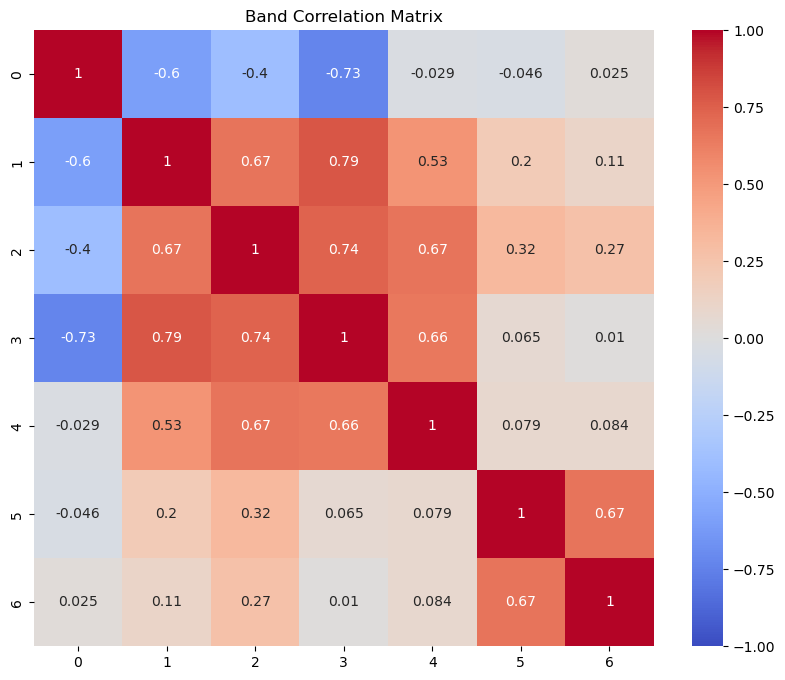

9031

In [38]:
print(new_names)
# Plot the correlation matrix
out_png = os.path.join(maindir,'figures/FigX_band_correlations_final.png')
band_correlations(stack_out_f_t, out_png)
gc.collect()

In [ ]:
# PERFORM BAND NORMALIZATION

In [39]:
scaler = StandardScaler() # from sklearn

image_np = stack_out_f_t.values # convert to numpy array

# Reshape the data to (bands, pixels)
bands, height, width = image_np.shape
image_np_t = image_np.reshape(bands, -1).T  # Transpose to get shape (pixels, bands)
# Create a mask for non-NaN values
valid_mask = ~np.isnan(image_np_t).any(axis=1)
# Handle NaN for the correlation matrix
image_np_tm = image_np_t[valid_mask]

# Fit the scalar transform to the data
image_np_tmn = scaler.fit_transform(image_np_tm)

# Reshape normalized data back to (bands, height, width)

# Create an empty array and place the normalized values back into the original shape
image_np_tmn_r = np.full(image_np_t.shape, np.nan)
image_np_tmn_r[valid_mask] = image_np_tmn
image_np_tmn_r = image_np_tmn_r.T.reshape(bands, height, width)

# Convert the normalized array back to a DataArray
stack_out_norm = xr.DataArray(
    image_np_tmn_r,
    dims=stack_out_f_t.dims,
    coords=stack_out_f_t.coords,
    attrs=stack_out_f_t.attrs
)

print(stack_out_norm.shape)

(7, 8223, 6714)


In [40]:
del image_np, image_np_t, valid_mask, image_np_tm, image_np_tmn, image_np_tmn_r
gc.collect()

0

In [41]:
# Save the normalized image array out with the correct CRS and compression
stack_out_norm_fp = os.path.join(maindir,'data/spatial/mod/dc_data/planet-data/dc_0623_psscene8b_final_norm.tif')

stack_out_norm.rio.write_crs(proj, inplace=True) # write the CRS
stack_out_norm.rio.to_raster(stack_out_norm_fp, compress='zstd', zstd_level=9, driver='GTiff', dtype='float32')

print(f"Saved raster stack to: {stack_out_norm_fp}")

Saved raster stack to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-rooftop-mapping/data/spatial/mod/dc_data/planet-data/dc_0623_psscene8b_final_norm.tif


In [42]:
gc.collect()

6